# **NLP Preprocessing and Modelling**

### **By:** Jiro Amato

### **Date:** June, 20, 2024

---

In this notebook, we wll be going through a first pass of preprocessing our training dataset for the sentiment analysis model. This dataset contains 4,840 financial articles that have been classified as positive, neutral or negative by 16 financial professionals. It is crucial to complete this step as it sets the foundation for the rest of the model. We will be looking through text-preprocessing and some EDA using techniques such as Bag of Words and TF-IDF to vecotrize the text data.

### ***Data Dictionary***

**Column Name:**   

- `Headline:` The headline of the news article
- `Sentiment:` Classifications by positive, neutral or negative. These classifications were agreed upon by 16 professionals in the Finance domain.

In [2]:
# Importing necessary libraries

# Libraries for data manipulation
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#  ML related libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Scalers
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# For memory caching
from tempfile import mkdtemp

# For Train/Test splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Sampling methods
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN

# NLP specific libraries
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import string

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amato\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Loading the data**

In [3]:
df = pd.read_csv('../data/df_clean.csv', index_col=0)
df.head()

,Headline,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


## ***Simplifying a multi-class problem into a binary problem***

In [4]:
# Mapping sentiments into binary (consolidating neutral into negative)

df['Sentiment'] = np.where(df['Sentiment'] == 'positive', 1, 0)

# Sanity check
df['Sentiment'].value_counts()

Sentiment
0    3477
1    1363
Name: count, dtype: int64

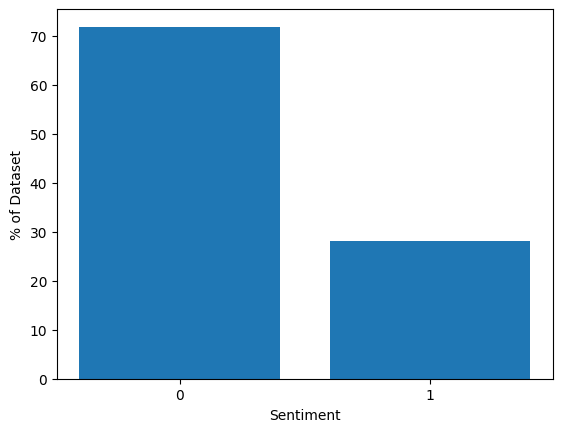

Class imbalance: [0.72 0.28]


In [6]:
# Class imbalance

values, counts = np.unique(df['Sentiment'], return_counts=True)
normalized_counts = counts/counts.sum()

plt.figure()
plt.bar(["0", "1"], normalized_counts*100) # plot normalized counts
plt.xlabel('Sentiment')
plt.ylabel('% of Dataset')
plt.show()

print(f"Class imbalance: {np.round(normalized_counts, 2)}")

As you can see the data is very imbalanced favouring the Negative/Neutral class at 72% while the Positive class is at 28%. We can suspect that model performance will be affected and will perform poorly in identifying the Positive class. We will continue in modelling with the current imbalance to see the baseline performance. Afterward, we will make the necessary changes to handle the imbalance classes.

## ***Tokenizer***

From the `1-NLP-Cleaning-EDA` notebook we created our own tokenizer. The components are below:

1. Standardization: Transforming text data into all lowercase and take out the punctuations
2. Tokenization: Splitting the documents into individual words
3. Stop-word removal: Removing words without significant meaning such as 'the' and 'like'
4. Lemmatization: Reducing words to their lemma (root)
5. Removal of short tokens with 1 or 2 elements

In [7]:
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def my_tokenizer(sentence):
    # transform string into lower case and take out punctuations
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '').lower()

    # tokenization
    listofwords = sentence.split(' ')
    lemmatized_words = []

    # removal of stop-words
    for word in listofwords:
        if word not in stop_words and (word != ''):
            # lemmatizing
            lemma = wnl.lemmatize(word)
            lemmatized_words.append(lemma)
            
    # Removing any other words with 1 or 2 letters that are insignificant        
    tokenized_list = [word for word in lemmatized_words if (len(word) != 1) and (len(word) != 2)]

    return tokenized_list

In [8]:
# Extracting columns

X = df['Headline']
y = df['Sentiment']

# Vectorizing
bagofwords = CountVectorizer(min_df=5, tokenizer=my_tokenizer, ngram_range=(1, 1))

# Fitting
bagofwords.fit(X)
X_bow = bagofwords.transform(X)

X_bow = pd.DataFrame(data=X_bow.toarray(), columns=bagofwords.get_feature_names_out())

X_bow

c:\Users\amato\anaconda3\envs\capstone\Lib\site-packages\sklearn\feature_extraction\text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,000,021,050,100,1000,10000,100000,105,110,112,...,yard,year,yearonyear,yesterday,yet,yit,york,zinc,zone,àland
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4838,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


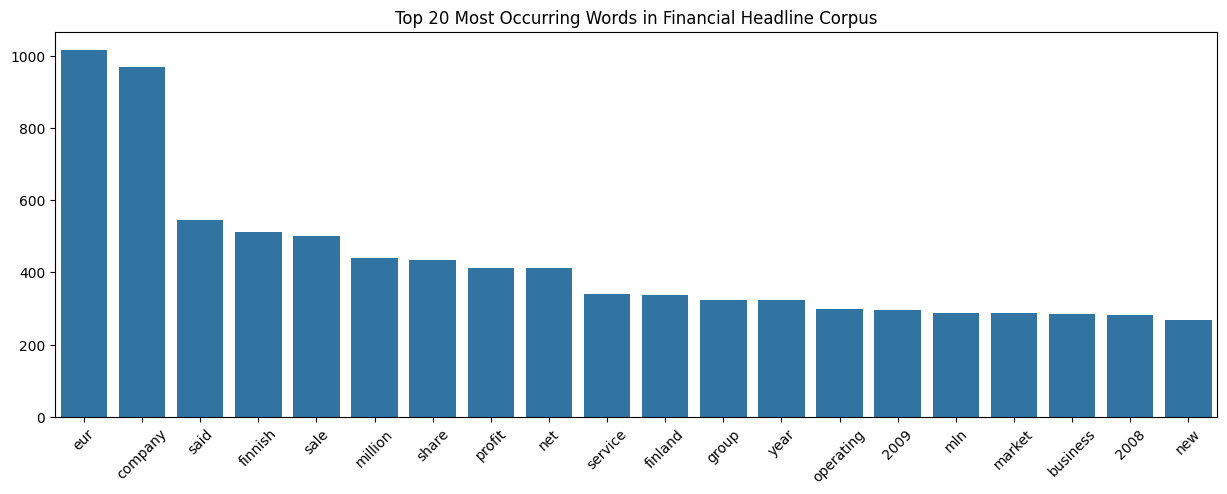

In [9]:
# Plotting most occuring words in the corpus of financial headlines
plt.figure(figsize=(15,5))
sns.barplot(X_bow.sum(axis=0).sort_values(ascending=False).head(20))
plt.title('Top 20 Most Occurring Words in Financial Headline Corpus')
plt.xticks(rotation=45)
plt.show()

# **Base Models**

## ***Logistic Regression***

For this model we will tune the hyperparameter $C$ which is the inverse of the regularization strength. We will also use `L1` penalty which effectively does feature selection for us. The solver used was `'saga'` which is faster on larger datasets than `liblinear`. Lastly, `StandardScaler()` was used in conjuction with a pipeline in order to scale the data at every fold.

In testing the base models, a five fold cross validation set was implemented.

In [10]:
# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y,
                                                      test_size=0.2,
                                                      stratify=y,
                                                      random_state=1)

# A list of Cs that we will experiment on
C_range = np.array([.000001,.00001,.0001,.001,0.01,\
                0.1,1,10,100,1000,10000,100000,1000000])

cross_validation_scores_LR = []
all_train_scores_LR = []

for C in C_range:
    LR = Pipeline([('scaler', StandardScaler()),
                   ('model', LogisticRegression(solver='saga',
                                                penalty='l1', C=C,
                                                random_state=1,
                                                max_iter=10000, n_jobs=-1))])
    
    # Train and cross validation scores
    scores = cross_validate(LR, X_remain, y_remain, cv=5, return_train_score=True)
    cv_score = np.mean(scores['test_score'])
    train_score = np.mean(scores['train_score'])
    
    # Append to overall list
    cross_validation_scores_LR.append(cv_score)
    all_train_scores_LR.append(train_score)

**Note** that the runtime for the code block above is 211 minutes and 55.4 seconds.

### ***Best Hyparameter (LR)***

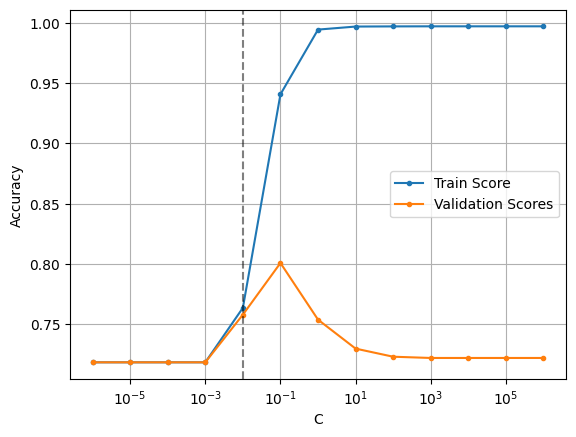

In [40]:
# Plotting results
C_range = np.array([.000001,.00001,.0001,.001,0.01,\
                0.1,1,10,100,1000,10000,100000,1000000])

plt.figure()
plt.plot(C_range, all_train_scores_LR, label='Train Score', marker='.')
plt.plot(C_range, cross_validation_scores_LR, label='Validation Scores', marker='.')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.axvline(0.01, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

In [49]:
# At C = 10**-1
print(f'At C=10**-1\nTrain Score: {all_train_scores_LR[np.where(C_range==0.1)[0][0]]}\
    \nCross Validation Score: {cross_validation_scores_LR[np.where(C_range==0.1)[0][0]]}\n')
print(f'At C=10**-2\nTrain Score: {all_train_scores_LR[np.where(C_range==0.01)[0][0]]}\
    \nCross Validation Score: {cross_validation_scores_LR[np.where(C_range==0.01)[0][0]]}')

At C=10**-1
Train Score: 0.940792845405485    
Cross Validation Score: 0.8008825539718263

At C=10**-2
Train Score: 0.7636880939987948    
Cross Validation Score: 0.7580055013753438


Here, we can see that the highest validation accuracy is when $C=10^{-1}$. However, the model is severely overfitting with train score at 0.941 and validation score at 0.801. The closest point from $C=10^{-1}$ where train and validation gap is the least but still retains a good amount of accuracy is $C=10^{-2}$. Here the model gives us comparable poerformance with train score being 0.764 and validation score being 0.758.

Now we will fit the Logistic Regresion Model where $C=10^{-2}$ and $Penalty=L1$

In [46]:
# Optimized LR model

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Scale the data
scaler = StandardScaler()
X_remain_scaled = scaler.fit_transform(X_remain)
X_test_scaled = scaler.transform(X_test)

# Fitting the model
LR = LogisticRegression(solver='liblinear', penalty='l1', C=0.01, max_iter=10000, random_state=1)
LR.fit(X_remain_scaled, y_remain)

# Scores
LR_train_score = LR.score(X_remain_scaled, y_remain)
LR_test_score = LR.score(X_test_scaled, y_test)

print(f'Train Score: {LR_train_score} \nTest Score: {LR_test_score}')

Train Score: 0.7835743801652892 
Test Score: 0.7985537190082644


The best logistic regression model is as follows:

| $C$ | Penalty                                 | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|-------|
| $10^{-1}$   | L1     | 0.758 | 0.784  | 0.799  |

## ***Decision Tree***

For Decision Tree, the initial hyperparemeter that we will be tuning is `max_depth` which is the maximum depth of the tree.

In [51]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# A list of max_depths for experimentation
depths = list(range(1, int(np.sqrt(len(X_remain)))))

cross_validation_scores_DT = {}
all_train_scores_DT = {}

for depth in depths:
    DT = DecisionTreeClassifier(max_depth=depth, random_state=1)
    
    # Train and cross validation scores
    scores = cross_validate(DT, X_remain, y_remain, cv=5, return_train_score=True)
    cv_score = np.mean(scores['test_score'])
    train_score = np.mean(scores['train_score'])
    
    # Append to overall list
    cross_validation_scores_DT[depth] = cv_score
    all_train_scores_DT[depth] = train_score

### ***Best Hyperparameter (DT)***

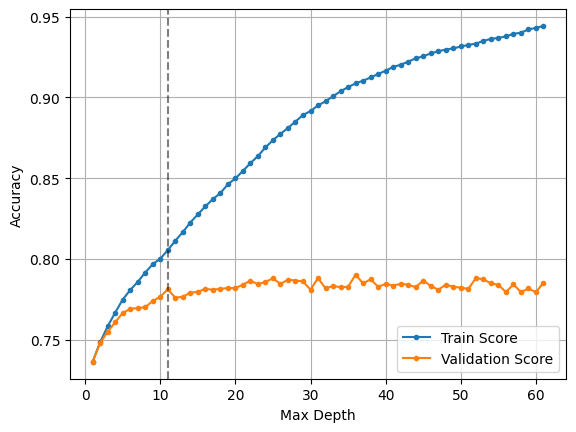

In [66]:
# Plotting results
depths = list(range(1, int(np.sqrt(len(X_remain)))))

plt.figure()
plt.plot(depths, all_train_scores_DT.values(), label="Train Score", marker=".")
plt.plot(depths, cross_validation_scores_DT.values(), label="Validation Score", marker=".")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.axvline(11, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

For the Decision Tree model, we can see that the Train Score continues to increase while the Validation Score reaches a plateau in which it oscilates over at around 0.78. This tells us that the model is overfitting the more we increase `max_depth`.

The `max_depth` that has a Validation Score that does not sacrifice accuracy while still being comparable to Train Score (not overfitting) would be 11. Any increase in `max_depth` will just continue to overfit to the training set with no gain in validation scores.

In [78]:
# Cross Validation Score
cross_validation_scores_DT[11]

0.7812509794115196

In [79]:
# Optimized DT Model

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Fitting the model
DT = DecisionTreeClassifier(max_depth=11, random_state=1)
DT.fit(X_remain, y_remain)

# Scores
DT_train_score = DT.score(X_remain, y_remain)
DT_test_score = DT.score(X_test, y_test)

print(f'Train Score: {DT_train_score} \nTest Score: {DT_test_score}')

Train Score: 0.8029442148760331 
Test Score: 0.8099173553719008


The best Decision Tree model is as follows:

| Max Depth | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 11   | 0.781 | 0.803  | 0.810   |

## ***K-Nearest Neighbours***

For KNN, the hyperparameter that we will be tuning is `n_neighbors` which is the number of neigbors to use in the algorithm. Note that the data is also scaled with `StandardScaler()` just like in Logistic Regression to ensure that larger features will not dominate the distance calculation in the algorithm.

In [65]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# A list of k_values to experiment on
k_values = list(range(1, 40))

cross_validation_scores_KNN = {}
all_train_scores_KNN = {}

for k in k_values:
    # Using a pipeline in order to scale the data at each fold
    KNN = Pipeline([("scaler", StandardScaler()),
                    ("model", KNeighborsClassifier(n_neighbors=k))])
    
    # Train and cross validation scores
    scores = cross_validate(KNN, X_remain, y_remain, cv=5, return_train_score=True)
    cv_score = np.mean(scores['test_score'])
    train_score = np.mean(scores['train_score'])
    
    # Append to overall list
    cross_validation_scores_KNN[k] = cv_score
    all_train_scores_KNN[k] = train_score

### ***Best Hyperparameter (KNN)***

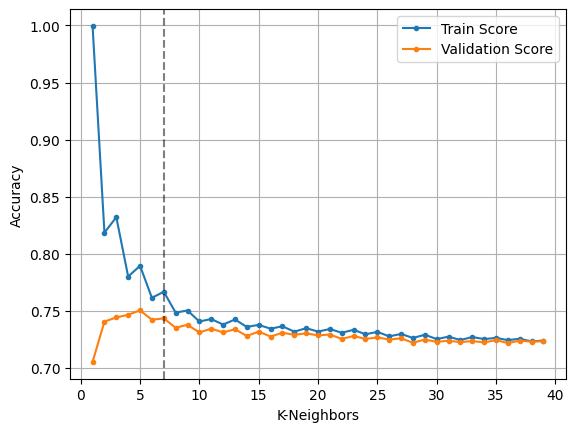

In [81]:
# Plotting results
k_values = list(range(1, 40))

plt.figure()
plt.plot(k_values, all_train_scores_KNN.values(), label="Train Score", marker=".")
plt.plot(k_values, cross_validation_scores_KNN.values(), label="Validation Score", marker=".")
plt.xlabel("K-Neighbors")
plt.ylabel("Accuracy")
plt.axvline(7, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

For the KNN model, we can see below that the Train Score decreases exponentially then tapers off to a plateau as we increase `K-Neighbors`. This is because initially, when `k = 1` each point is its own neighbor which the model memorizes and gets 100% accuracy on the Train set but does poorly on the Validation sets. As `k` increases, there are more neighbors that the model considers to make its predictions resulting in decreasing performance on the Train set and better performance for the Validation set (up to a certain point). The Validation scores peak when `k = 5` and decreases but in a slower fashion.

The `K-Neighbors` that has a Validation Score that doesn't not sacrifice overfitting while retaining decent accuracy would be 7. Any increase in `K-Neigbors` will decrease the Validation score albeit being closer to Train score.

In [82]:
# Cross Validation Score
cross_validation_scores_KNN[7]

0.7432821538718013

In [88]:
# Optimized KNN Model

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Scale the data
scaler = StandardScaler()
X_remain_scaled = scaler.fit_transform(X_remain)
X_test_scaled = scaler.transform(X_test)

# Fitting the model
KNN = KNeighborsClassifier(n_neighbors=7)
KNN.fit(X_remain_scaled, y_remain)

# Scores
KNN_train_score = KNN.score(X_remain_scaled, y_remain)
KNN_test_score = KNN.score(X_test_scaled, y_test)

print(f'Train Score: {KNN_train_score} \nTest Score: {KNN_test_score}')

Train Score: 0.7758264462809917 
Test Score: 0.7427685950413223


The best KNN model is as follows:

| K-Neighbours | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 6   | 0.743 | 0.776  | 0.743   |

## ***Naïve Bayes***

For Naïve Bayes, the hyperparameter that we will be tuning is the `alpha` which is the smoothing technique (Laplace Smoothing) that is applied in order to handle features (words in our case) with zero probabilities. The alpha is added to the counts of each feature and the probabilities of each word approach a uniform distribution as we increase `alpha`.

In [89]:
# Train/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

alpha_values = list(range(1, 20))

cross_validation_scores_NB = {}
all_train_scores_NB = {}

for alpha in alpha_values:
    NB = MultinomialNB(alpha=alpha)
    
    # Train and cross validation scores
    scores = cross_validate(NB, X_remain, y_remain, cv=5, return_train_score=True)
    cv_score = np.mean(scores['test_score'])
    train_score = np.mean(scores['train_score'])
    
    # Append to overall list
    cross_validation_scores_NB[alpha] = cv_score
    all_train_scores_NB[alpha] = train_score

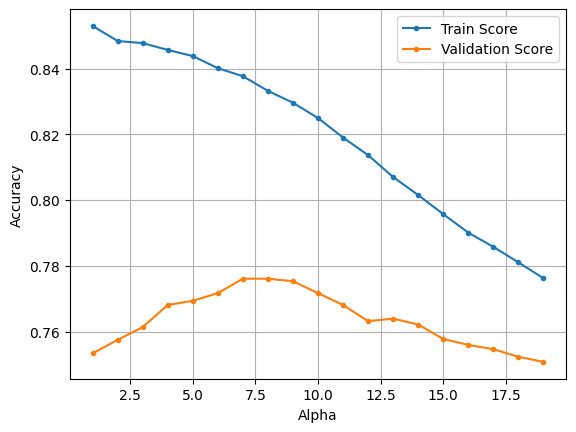

In [39]:
# Don't RUN

plt.figure()
plt.plot(alpha_values, all_train_scores_NB, label="Train Score", marker=".")
plt.plot(alpha_values, cross_validation_scores_NB, label="Validation Score", marker=".")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

### ***Best Hyperparameter (NB)***

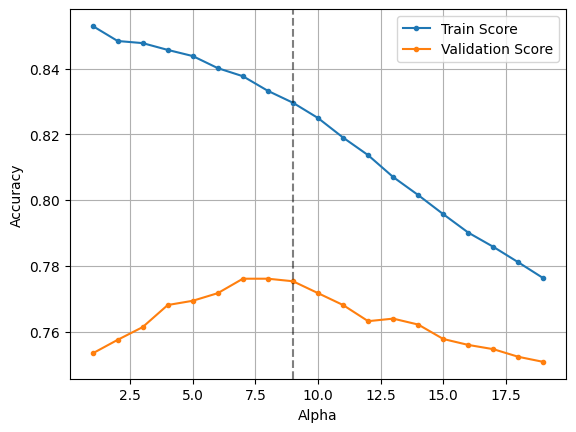

In [92]:
# Plotting results
alpha_values = list(range(1, 20))

plt.figure()
plt.plot(alpha_values, all_train_scores_NB.values(), label="Train Score", marker=".")
plt.plot(alpha_values, cross_validation_scores_NB.values(), label="Validation Score", marker=".")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.axvline(9, linestyle='--', alpha=0.5, color='black')
plt.grid()
plt.legend()
plt.show()

For the Naïve Bayes model, we can see below that the Train Score continually decreases as we increase `Alpha`. This is because the probabilities of words having a Negative/Neutral (0) or Positive (1) sentiment approaches 0.5 meaning that the model is less determinent (or confident) in its soft predictions. Therefore, as `Alpha` increases, the model is less able to fit the training data because of the increased smoothing.  

For Validation Score, at lower values of `Alpha`, the model is overfitting to the Train set which leads to poor performance in the Validation set. Validation Score increases from `Alpha = 1` to `Alpha = 7` and then decreases thereafter. This tells us that the model generalizes best on unseen data at around `Alpha = 7`. 

The model that best captures the Bias and Variance trade-off is at `Alpha = 9`. Although we are losing ***some*** Validation accuracy compared to `Alpha = 7` the gap between Validation and Train score at `Alpha = 9` is much lower compared to `Alpha = 7` so this will be the best hyperparameter setting for Naïve Bayes.

**Note** that the model is very much overfitting regardless.

In [97]:
# Cross Validation Score
cross_validation_scores_NB[9]

0.7753108277069266

In [98]:
# Optimized NB Model

# Remainder/Test Split
X_remain, X_test, y_remain, y_test = train_test_split(X_bow, y, test_size=0.2, stratify=y, random_state=1)

# Fitting the model
NB = MultinomialNB(alpha=9)
NB.fit(X_remain, y_remain)

# Scores
NB_train_score = NB.score(X_remain, y_remain)
NB_test_score = NB.score(X_test, y_test)

print(f"Train Score: {NB_train_score} \nTest Score: {NB_test_score}")

Train Score: 0.8267045454545454 
Test Score: 0.7840909090909091


The best Naïve Bayes model is as follows:

| Alpha | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 9   | 0.775 | 0.827  | 0.784   |

## **Comparing all base models**

**Logistic Regression**:

| $C$ | Penalty                                 | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|-------|
| $10^{-1}$   | L1     | 0.758 | 0.784  | 0.799  |

**Decision Tree**:

The best Decision Tree model is as follows:

| Max Depth | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 11   | 0.781 | 0.803  | 0.810   |

**KNN**:

| K-Neighbours | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 6   | 0.743 | 0.776  | 0.743   |

**Naïve-Bayes**:

| Alpha | Cross Validation Score    | Train Score    | Test Score    |
|-------|--------------------------------------------|-------|-------|
| 9   | 0.775 | 0.827  | 0.784   |

Based on the first pass of hyperparameter tuning of all the models, the ***Decision Tree*** model has the highest accuracy in the Test Set. However, since our data is **imbalanced** in favour of Class 0 (Negative/Neutral), this is actually misleading. The next [section](#model-evaluation) explores how these models compare in identifying the positive class which is the class that is also crucial to us as a positive sentiment may lead to higher stock prices.

# **Model Evaluation**

This section explores all the base models' performance in identifying Class 0 (Negative/Neutral) and Class 1 (Positive).

## ***Logistic Regression***

### ***Confusion Matrix***

Text(0.5, 1.0, 'Confusion Matrix: Logistic Regression Model')

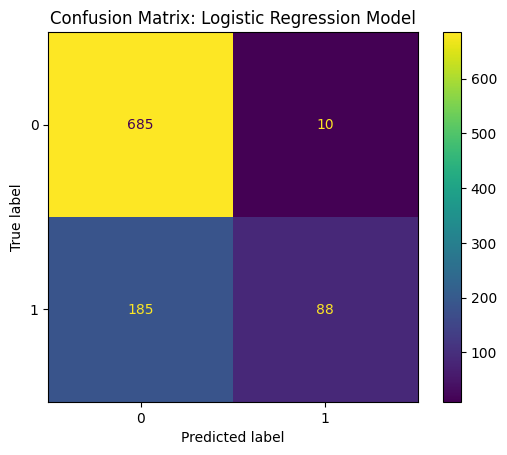

In [99]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(LR, X_test_scaled, y_test) # Using scaled data for Logistic Regression
plt.title('Confusion Matrix: Logistic Regression Model')

### ***Classification Report***

In [100]:
# Classification Report
from sklearn.metrics import classification_report

y_pred_LR = LR.predict(X_test_scaled)

report_LR = classification_report(y_test, y_pred_LR)
print(report_LR)

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       695
           1       0.90      0.32      0.47       273

    accuracy                           0.80       968
   macro avg       0.84      0.65      0.67       968
weighted avg       0.82      0.80      0.76       968



### ***ROC Curve***

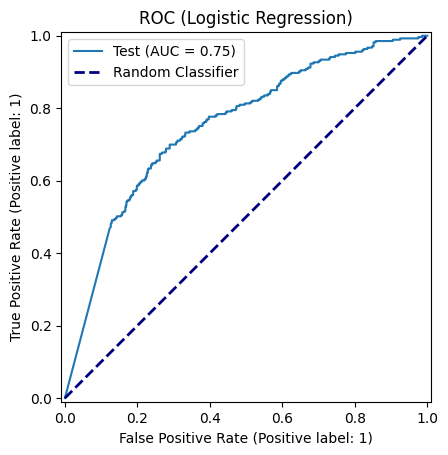

In [57]:
from sklearn.metrics import RocCurveDisplay

# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(LR_model, X_test, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC (Logistic Regression)')
plt.show()

## ***Decision Tree***

### ***Confusion Matrix***

Text(0.5, 1.0, 'Confusion Matrix on Test Data: Decision Tree')

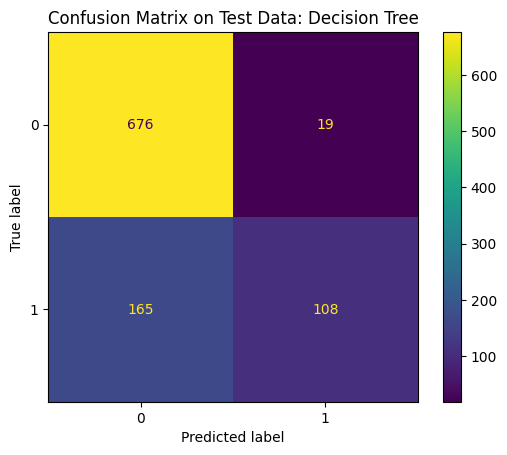

In [45]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(DT, X_test, y_test)
plt.title('Confusion Matrix on Test Data: Decision Tree')

### ***Classification Report***

In [46]:
# Classification Report
y_pred_DT = DT.predict(X_test)

report_DT = classification_report(y_test, y_pred_DT)
print(report_DT)

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       695
           1       0.85      0.40      0.54       273

    accuracy                           0.81       968
   macro avg       0.83      0.68      0.71       968
weighted avg       0.82      0.81      0.78       968



### ***ROC Curve***

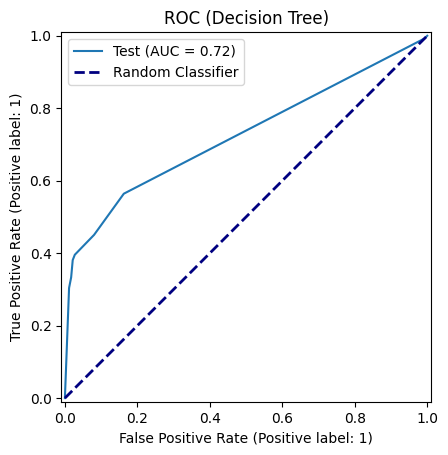

In [60]:
# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(DT, X_test, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC (Decision Tree)')
plt.show()

## ***KNN***

### ***Confusion Matrix***

c:\Users\amato\anaconda3\envs\capstone\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix on Test Data: KNN')

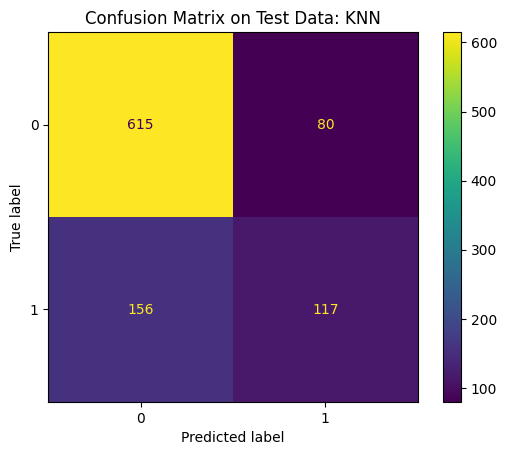

In [48]:
# Confusion Matrix

scaler = StandardScaler().fit(X_test)
X_test_scaled = scaler.transform(X_test)

ConfusionMatrixDisplay.from_estimator(KNN, X_test_scaled, y_test)
plt.title('Confusion Matrix on Test Data: KNN')

### ***Classification Report***

In [49]:
# Classification Report

y_pred_KNN = KNN.predict(X_test_scaled)

report_KNN = classification_report(y_test, y_pred_KNN)
print(report_KNN)

c:\Users\amato\anaconda3\envs\capstone\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.88      0.84       695
           1       0.59      0.43      0.50       273

    accuracy                           0.76       968
   macro avg       0.70      0.66      0.67       968
weighted avg       0.74      0.76      0.74       968



### ***ROC Curve***

c:\Users\amato\anaconda3\envs\capstone\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


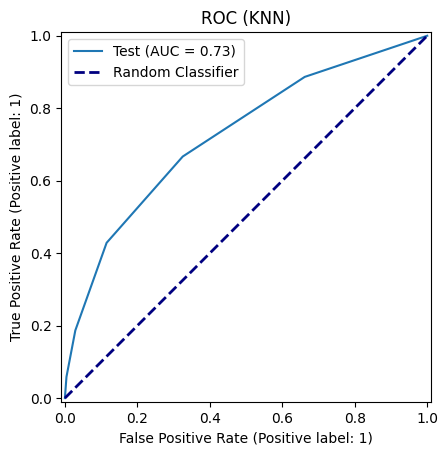

In [63]:
# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(KNN, X_test_scaled, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC (KNN)')
plt.show()

## ***Naïve Bayes***

### ***Confusion Matrix***

Text(0.5, 1.0, 'Confusion Matrix on Test Data: Naive-Bayes')

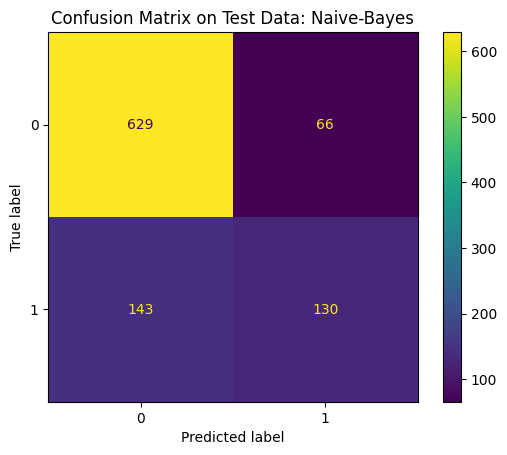

In [51]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(NB, X_test, y_test)
plt.title('Confusion Matrix on Test Data: Naive-Bayes')

### ***Classification Report***

In [52]:
# Classification Report
y_pred_NB = NB.predict(X_test)

report_NB = classification_report(y_test, y_pred_NB)
print(report_NB)

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       695
           1       0.66      0.48      0.55       273

    accuracy                           0.78       968
   macro avg       0.74      0.69      0.71       968
weighted avg       0.77      0.78      0.77       968



### ***ROC Curve***

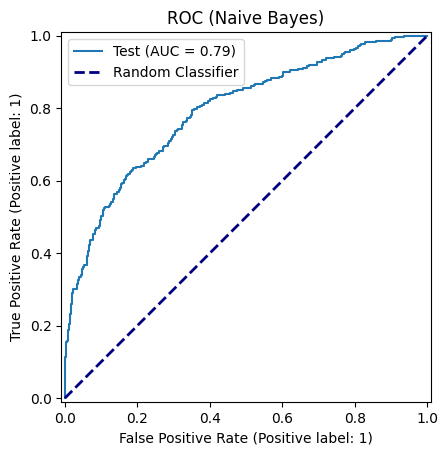

In [66]:
# ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(NB, X_test, y_test, name='Test', pos_label=1, ax=ax)
plt.plot([0, 1], [0, 1], color='navy', lw=2, ls='--', label='Random Classifier')
plt.legend()
plt.title('ROC (Naive Bayes)')
plt.show()